In [1]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.svm import SVR, LinearSVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import os
import re
import shap
import pandas_profiling as ppf
import seaborn as sns
import matplotlib.pyplot as plt

import re
from collections import Counter
from operator import itemgetter
import time
from itertools import product
import datetime as dt
import calendar
import gc

RANDOM_SEED = 42

In [2]:
PATH = '../input/competitive-data-science-predict-future-sales'
items = pd.read_csv(PATH + '/items.csv')
shops = pd.read_csv(PATH + '/shops.csv')
cats = pd.read_csv(PATH + '/item_categories.csv')
train = pd.read_csv(PATH + '/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv(PATH + '/test.csv').set_index('ID')

In [3]:
# train.date = pd.to_datetime(train.date.index)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
def summary_stats_table(data):
    '''
    a functino to summerize all types of data
    '''
    # count of nulls
    missing_counts = pd.DataFrame(data.isnull().sum())
    missing_counts.columns = ['count_null']

    # numeric column stats
    num_stats = data.select_dtypes(include=['int64','float64']).describe().loc[['count','min','max']].transpose()
    num_stats['dtype'] = data.select_dtypes(include=['int64','float64']).dtypes.tolist()

    # non-numeric value stats
    non_num_stats = data.select_dtypes(exclude=['int64','float64']).describe().transpose()
    non_num_stats['dtype'] = data.select_dtypes(exclude=['int64','float64']).dtypes.tolist()
    non_num_stats = non_num_stats.rename(columns={"first": "min", "last": "max"})

    # merge all 
    stats_merge = pd.concat([num_stats, non_num_stats], axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True).fillna("").sort_values('dtype')

    column_order = ['dtype', 'count', 'count_null','unique','min','max','top','freq']
    summary_stats = pd.merge(stats_merge, missing_counts, left_index=True, right_index=True)[column_order]
    return(summary_stats)

# Check data

## File
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

## Columns

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [5]:
print(train.head())
print(test.head())

# print(items.head())
# print(shops.head())
# print(cats.head())


         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
    shop_id  item_id
ID                  
0         5     5037
1         5     5320
2         5     5233
3         5     5232
4         5     5268


In [6]:
summary_stats_table(train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,dtype,count,count_null,unique,min,max,top,freq
date_block_num,int64,2935849.0,0,,0,33,,
shop_id,int64,2935849.0,0,,0,59,,
item_id,int64,2935849.0,0,,0,22169,,
item_price,float64,2935849.0,0,,-1,307980,,
item_cnt_day,float64,2935849.0,0,,-22,2169,,
date,object,2935849.0,0,1034,,,28.12.2013,9434


# Data clearn

In [7]:
## Drop item_price and item_cnt_day too high
train = train[train.item_price<100000] # drop 1
train = train[train.item_cnt_day<1000] # drop 2

## Drop negative price 
train = train[train.item_price > 0].reset_index(drop=True) # drop 1

## The item has been returned 
# train.loc[train.item_cnt_day < -2, 'item_cnt_day'] = -3
train.loc[train.item_cnt_day < 0, 'item_cnt_day'] = 0

## Fuse some shop in train and test set
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 11, 'shop_id'] = 10
# РостовНаДону ТРК "Мегацентр Горизонт" Островной
train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39



# Categorize shops info


In [8]:
## Define shop city and category
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['category'] = shops['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

## Shop category
category = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shops.category = shops.category.apply(lambda x: x if (x in category) else 'etc')
shops.groupby(['category']).sum()

## Shop city
shops['shop_city'] = shops.city
shops['shop_category'] = shops.category

shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_category'] = LabelEncoder().fit_transform(shops['shop_category'])

shops = shops[['shop_id','shop_city', 'shop_category']]
shops.head()


,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


# cats info

In [9]:
## Fuse some item_category_name
cats['type_code'] = cats.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
cats.loc[(cats.type_code == 'Игровые') | (cats.type_code == 'Аксессуары'), 'type_code'] = 'Игры'
cats.loc[cats.type_code == 'PC', 'type_code'] = 'Музыка'

## Labelencoder item_category_name (main category) to type_code
category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']
cats['type_code'] = cats.type_code.apply(lambda x: x if (x in category) else 'etc')
cats['type_code'] = LabelEncoder().fit_transform(cats['type_code'])

## Labelencoder item_category_name (sub category) to subtype_code
cats['split'] = cats.item_category_name.apply(lambda x: x.split('-'))
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])

cats = cats[['item_category_id','type_code', 'subtype_code']]


# items info

In [10]:
## Extract info in [] and ()
items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

## Replace symbol by ',])'... by ' ' 
items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

## Test
result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)


## Fuse some types
items['type'] = items.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
items.loc[(items.type == 'x360') | (items.type == 'xbox360'), 'type'] = 'xbox 360'
items.loc[items.type == '', 'type'] = 'mac'
items.type = items.type.apply(lambda x: x.replace(' ',''))
items.loc[(items.type == 'pc') | (items.type == 'pс') | (items.type == 'рс'), 'type'] = 'pc'
items.loc[(items.type == 'рs3'), 'type'] = 'ps3'

## Find low frequence item type
# group_count = items[['item_id', 'type']].groupby('type').count()
# drop_list = group_count.loc[group_count.item_id < 10].index
group_sum = items.groupby('type').sum()
drop_list = group_sum.loc[group_sum.item_category_id < 200].index

print('drop list:', drop_list)

## Replece low frequence item type by etc in name_2
items.name_2 = items.type.apply(lambda x: 'etc' if x in drop_list else x)
items = items.drop(['type'], axis=1)
print(items.groupby('name_2').count()[['item_id']])

## Labelencoder name_2, name_3
items['name_2'] = LabelEncoder().fit_transform(items['name_2']).astype(np.int8)
items['name_3'] = LabelEncoder().fit_transform(items['name_3']).astype(np.int16)
items.drop(['item_name', 'name_1'], axis=1, inplace=True)

Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320
drop list: Index(['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72',
       'kf6', 'kf7', 'kg4', 'p', 'ps2', 's3v', 's4v', 'англ', 'русская',
       'только', 'цифров'],
      dtype='object', name='type')
          item_id
name_2           
0           17661
etc            35
mac            42
pc           2642
ps             79
ps3           611
ps4           174
psp           115
xbox360       466
xboxone       123
циф

# Month sales treatment


In [11]:
## Prepare matrix for (shop_id，item_id) couple
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print('Use time:', time.time() - ts)


Use time: 19.756067276000977


In [12]:
## revenue from one item on one day's sale
train['revenue'] = train['item_price'] *  train['item_cnt_day']

## Fill known month sale data in the matrix (all (shop_id，item_id) couple)
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})

group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)#.astype(np.float16))
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
print('Use time:', time.time() - ts)



Use time: 5.8900628089904785


# Test set preparation

In [13]:
# Add test 34 month to matrix
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
print('Use time:', time.time() - ts)


Use time: 0.12831687927246094


# Shops/Items/Cats features

In [14]:
## Attach shop, item, item_category information to the matrix

ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['shop_city'] = matrix['shop_city'].astype(np.int8)
matrix['shop_category'] = matrix['shop_category'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

print('Use time:', time.time() - ts)


Use time: 4.434855222702026


# Traget lags

In [15]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'-lag'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [16]:
## Lag 1,2,3 month
ts = time.time()
matrix = lag_feature(matrix, [1,2,3], 'item_cnt_month')
print('Use time:', time.time() - ts)


Use time: 22.19626522064209


# Mean encoded features

In [17]:
## Simplyfy feauture name dictionaries:
dict_simple = {'date_block_num': 'date', 'item_id': 'item', 'shop_id': 'shop', 
               'item_category_id': 'itemcate', 'item_price':'price', 
               
               'item_cnt_month': 'cnt', }

## Functions for groupby and aggregate
def sum_names(name_list):
    names = ''
    for x in name_list:
        names += x+'+'
    return names
    
def group_agg(matrix, groupby_feats, transform_feat, aggtype='mean'):
    group = matrix.groupby(groupby_feats).agg({transform_feat: [aggtype]})
    groupby_feats_simple = [dict_simple[x] if x in dict_simple.keys() else x
                            for x in groupby_feats]
    transform_feat_simple = dict_simple[transform_feat] \
                            if transform_feat in dict_simple.keys() else transform_feat
    group_name = f'{sum_names(groupby_feats_simple)[:-1]}-{aggtype.upper()}-{transform_feat_simple}'
    group.columns = [ group_name ]
    group.reset_index(inplace=True)
    return group, group_name
    
def add_groupmean_lag(matrix, groupby_feats, transform_feat, lags):
    group, group_name = group_agg(matrix, groupby_feats, transform_feat)
    
    matrix = pd.merge(matrix, group, on=groupby_feats, how='left')
    matrix[group_name] = matrix[group_name].astype(np.float16)
    if lags != []:
        matrix = lag_feature(matrix, lags, group_name)
        matrix.drop([group_name], axis=1, inplace=True)
    return matrix
    


In [18]:
ts = time.time()

## Compute mean item_cnt_month (cnt) 
transform_feat = 'item_cnt_month'


groupby_feats = ['date_block_num']
lags = [1]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

groupby_feats = ['date_block_num', 'item_id']
lags = [1,2,3]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

groupby_feats = ['date_block_num', 'shop_id']
lags = [1,2,3]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

groupby_feats = ['date_block_num', 'item_category_id']
lags = [1]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

groupby_feats = ['date_block_num', 'shop_id', 'item_category_id']
lags = [1]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

groupby_feats = ['date_block_num', 'shop_id', 'item_id']
lags = [1]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

groupby_feats = ['date_block_num', 'shop_id', 'subtype_code']
lags = [1]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

groupby_feats = ['date_block_num', 'shop_city']
lags = [1]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

groupby_feats = ['date_block_num', 'item_id', 'shop_city']
lags = [1]
matrix = add_groupmean_lag(matrix, groupby_feats, transform_feat, lags)

print('Use time:', time.time() - ts)


Use time: 177.0180540084839


# Trend Features
## Price trend

In [19]:
ts = time.time()

fetures_to_drop = []

## caculate mean price for every item
transform_feat = 'item_price'
groupby_feats = ['item_id']
group, mean_price_col = group_agg(train, groupby_feats, 
                                  transform_feat, aggtype='mean')
matrix = pd.merge(matrix, group, on=groupby_feats, how='left')
matrix[mean_price_col] = matrix[mean_price_col].astype(np.float16)


## caculate mean date (monthly) price for every item
transform_feat = 'item_price'
groupby_feats = ['date_block_num','item_id']
group, mean_monthlyprice_col = group_agg(train, groupby_feats, 
                                         transform_feat, aggtype='mean')
matrix = pd.merge(matrix, group, on=groupby_feats, how='left')
matrix[mean_monthlyprice_col] = matrix[mean_monthlyprice_col].astype(np.float16)


## create time lags for date date (monthly) price
lags = [1,2,3]
matrix = lag_feature(matrix, lags, mean_monthlyprice_col)

## delta between date (monthly) mean and mean price for every lag
for i in lags:
    matrix['delta_price-lag'+str(i)] = \
    (matrix[f'{mean_monthlyprice_col}-lag'+str(i)] - matrix[mean_price_col])\
    / matrix[mean_price_col]


############### Too slow ###############
# def select_trend(row):
#     for i in lags:
#         if row['delta_price-lag'+str(i)]:
#             return row['delta_price-lag'+str(i)]
#     return 0
# matrix['delta_price-lag'] = matrix.apply(select_trend, axis=1)

############### 10 times faster ###############
matrix['delta_price-lag']=0
bool_loc = np.ones(len(matrix))==1
for i in lags:   
    matrix.loc[bool_loc, 'delta_price-lag'] = matrix.loc[bool_loc,'delta_price-lag'+str(i)]
    bool_loc &= matrix['delta_price-lag'+str(i)]==0
matrix['delta_price-lag'] = matrix['delta_price-lag'].astype(np.float16)
matrix['delta_price-lag'].fillna(0, inplace=True)

## Only keep 'delta_price_lag' feature
fetures_to_drop.append(mean_price_col)
fetures_to_drop.append(mean_monthlyprice_col)
for i in lags:
    fetures_to_drop += [f'{mean_monthlyprice_col}-lag'+str(i)]
    fetures_to_drop += ['delta_price-lag'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)
print('Use time:', time.time() - ts)


Use time: 37.52592396736145


## Revenue trend

In [20]:
ts = time.time()

## Monthly shop revenue sum
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)


## Shop mean revenue from Monthly shop revenue sum
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

## delta between date (monthly) revenue and mean revenue
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

## revenue lags
matrix = lag_feature(matrix, [1], 'delta_revenue')

## Only keep lag 'delta_revenue' feature
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

print('Use time:', time.time() - ts)



Use time: 17.135472536087036


# Date info

In [21]:
## Date information
total_block_num = 35
date_block_num = np.arange(total_block_num)
date_block = [pd.Timestamp(2013, 1, 1)+pd.DateOffset(months=x) for x in date_block_num]


df_date = pd.DataFrame(date_block_num, columns=['date_block_num'])
df_date['date_block'] = date_block
df_date['year'] = df_date['date_block'].dt.year
df_date['month'] = df_date['date_block'].dt.month

for i in range(len(df_date)):
    day_to_count = 0
    calendar_matrix = calendar.monthcalendar(df_date['year'].iloc[i],df_date['month'].iloc[i])
    for j in range(7): # 7 days a week
        num_days = sum(1 for x in calendar_matrix if x[j] != 0)
        df_date.loc[i, f'week{j}'] = num_days
df_date = df_date[['date_block_num', 'year','month','week0','week1',
                   'week2','week3','week4','week5','week6']]  
df_date['days'] = df_date[['week0','week1','week2','week3','week4','week5','week6']].sum(axis=1)
df_date['year'] = df_date['year']-2012
df_date = df_date.astype(np.int8)

matrix = pd.merge(matrix, df_date, on=['date_block_num'], how='left')


In [22]:
## The first month when one item is on sale
matrix['item_shop_first_sale'] = \
matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')

matrix['item_first_sale'] = \
matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')



In [23]:
## Drop 3 first date (because of lag)
matrix = matrix[matrix.date_block_num > 3]



In [24]:
############### ???????????? ###############

def fill_na(df):
    for col in df.columns:
        if ('-lag' in col) & (df[col].isnull().any()):
            print(col)
            if ('cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

item_cnt_month-lag1
item_cnt_month-lag2
item_cnt_month-lag3
date-MEAN-cnt-lag1
date+item-MEAN-cnt-lag1
date+item-MEAN-cnt-lag2
date+item-MEAN-cnt-lag3
date+shop-MEAN-cnt-lag1
date+shop-MEAN-cnt-lag2
date+shop-MEAN-cnt-lag3
date+itemcate-MEAN-cnt-lag1
date+shop+itemcate-MEAN-cnt-lag1
date+shop+item-MEAN-cnt-lag1
date+shop+subtype_code-MEAN-cnt-lag1
date+shop_city-MEAN-cnt-lag1
date+item+shop_city-MEAN-cnt-lag1
delta_revenue-lag1


In [25]:
matrix.isna().sum()

date_block_num                                0
shop_id                                       0
item_id                                       0
item_cnt_month                                0
shop_city                                     0
shop_category                                 0
item_category_id                              0
name_2                                        0
name_3                                        0
type_code                                     0
subtype_code                                  0
item_cnt_month-lag1                           0
item_cnt_month-lag2                           0
item_cnt_month-lag3                           0
date-MEAN-cnt-lag1                            0
date+item-MEAN-cnt-lag1                       0
date+item-MEAN-cnt-lag2                       0
date+item-MEAN-cnt-lag3                       0
date+shop-MEAN-cnt-lag1                       0
date+shop-MEAN-cnt-lag2                       0
date+shop-MEAN-cnt-lag3                 

In [26]:
import pickle
import gc

del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

matrix.to_pickle('../working/data.pkl')

del matrix
gc.collect();

# Train 

In [27]:
data = pd.read_pickle('../working/data.pkl')
# data = matrix
# del matrix

test  = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')

print(len(data.columns))
data.columns

41


Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_category', 'item_category_id', 'name_2', 'name_3', 'type_code',
       'subtype_code', 'item_cnt_month-lag1', 'item_cnt_month-lag2',
       'item_cnt_month-lag3', 'date-MEAN-cnt-lag1', 'date+item-MEAN-cnt-lag1',
       'date+item-MEAN-cnt-lag2', 'date+item-MEAN-cnt-lag3',
       'date+shop-MEAN-cnt-lag1', 'date+shop-MEAN-cnt-lag2',
       'date+shop-MEAN-cnt-lag3', 'date+itemcate-MEAN-cnt-lag1',
       'date+shop+itemcate-MEAN-cnt-lag1', 'date+shop+item-MEAN-cnt-lag1',
       'date+shop+subtype_code-MEAN-cnt-lag1', 'date+shop_city-MEAN-cnt-lag1',
       'date+item+shop_city-MEAN-cnt-lag1', 'delta_price-lag',
       'delta_revenue-lag1', 'year', 'month', 'week0', 'week1', 'week2',
       'week3', 'week4', 'week5', 'week6', 'days', 'item_shop_first_sale',
       'item_first_sale'],
      dtype='object')

In [28]:
# data = data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
#        'shop_category', 'item_category_id', 'name_2', 'name_3', 'type_code',
#        'subtype_code', 'item_cnt_month-lag1', 'item_cnt_month-lag2',
#        'item_cnt_month-lag3', 'date-MEAN-cnt-lag1',
#        'date+item-MEAN-cnt-lag1', 'date+item-MEAN-cnt-lag2',
#        'date+item-MEAN-cnt-lag3', 'date+shop-MEAN-cnt-lag1',
#        'date+shop-MEAN-cnt-lag2', 'date+shop-MEAN-cnt-lag3',
#        'date+itemcate-MEAN-cnt-lag1', 'date+shop+itemcate-MEAN-cnt-lag1',
#        'date+shop+item-MEAN-cnt-lag1',
#        'date+shop+subtype_code-MEAN-cnt-lag1',
#        'date+shop_city-MEAN-cnt-lag1', 'date+item+shop_city-MEAN-cnt-lag1',
#        'delta_price-lag',
#        'delta_revenue-lag1', 'month', 'days', 'item_shop_first_sale',
#        'item_first_sale']]

In [29]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']

X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del data
gc.collect();

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9106440 entries, 1497465 to 10603904
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
shop_city                               int8
shop_category                           int8
item_category_id                        int8
name_2                                  int8
name_3                                  int16
type_code                               int8
subtype_code                            int8
item_cnt_month-lag1                     float16
item_cnt_month-lag2                     float16
item_cnt_month-lag3                     float16
date-MEAN-cnt-lag1                      float16
date+item-MEAN-cnt-lag1                 float16
date+item-MEAN-cnt-lag2                 float16
date+item-MEAN-cnt-lag3                 float16
date+shop-MEAN-cnt-lag1                 float16
date+shop-MEAN-cnt-lag2                 floa

In [31]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

del X_train
gc.collect();

In [32]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# params = {'num_leaves': 512, 'max_depth': 25, 'max_bin': 128, 'n_estimators': 3000, 
#           'bagging_freq': 7, 'bagging_fraction': 0.6, 
#           'feature_fraction': 0.2, 'min_data_in_leaf': 78, 
#           'learning_rate': 0.1, 'num_threads': 6, 
#           'min_sum_hessian_in_leaf': 6,

#           'random_state' : RANDOM_SEED,
#           'verbosity' : 1,
#           'bagging_seed' : RANDOM_SEED,
#           'boost_from_average' : 'true',
#           'boost' : 'gbdt',
#           'metric' : 'rmse',
# }

params = {'num_leaves': 2000, 'max_depth': 19, 'max_bin': 107, 'n_estimators': 3747,
          'bagging_freq': 1, 'bagging_fraction': 0.7135681370918421, 
          'feature_fraction': 0.49446461478601994, 'min_data_in_leaf': 88, 
          'learning_rate': 0.015980721586917768, 'num_threads': 3, 
          'min_sum_hessian_in_leaf': 6,
         
          'random_state' : RANDOM_SEED,
          'verbosity' : 1,
          'bagging_seed' : RANDOM_SEED,
          'boost_from_average' : 'true',
          'boost' : 'gbdt',
          'metric' : 'rmse',}

model = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=[lgb_train,lgb_eval],
                early_stopping_rounds=20,
                verbose_eval=1,
                )
y_pred = model.predict(X_valid)
rmsle(Y_valid, y_pred)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 1.21239	valid_1's rmse: 1.13077
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 1.20299	valid_1's rmse: 1.12437
[3]	training's rmse: 1.19389	valid_1's rmse: 1.11847
[4]	training's rmse: 1.1851	valid_1's rmse: 1.1118
[5]	training's rmse: 1.17653	valid_1's rmse: 1.10536
[6]	training's rmse: 1.16788	valid_1's rmse: 1.09874
[7]	training's rmse: 1.15953	valid_1's rmse: 1.09317
[8]	training's rmse: 1.15118	valid_1's rmse: 1.08703
[9]	training's rmse: 1.14345	valid_1's rmse: 1.08148
[10]	training's rmse: 1.13668	valid_1's rmse: 1.07672
[11]	training's rmse: 1.12941	valid_1's rmse: 1.07229
[12]	training's rmse: 1.12148	valid_1's rmse: 1.06689
[13]	training's rmse: 1.11388	valid_1's rmse: 1.06166
[14]	training's rmse: 1.10661	valid_1's rmse: 1.05627
[15]	training's rmse: 1.0992	valid_1's rmse: 1.05164
[16]	training's rmse: 1.09214	valid_1's rmse: 1.04607
[17]	training's rmse: 1.08529	valid_1's rmse: 1.04088
[18]	training's rmse: 1.0783	vali

0.8962350082076307

In [33]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('lgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('lgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('lgb_test.pickle', 'wb'))

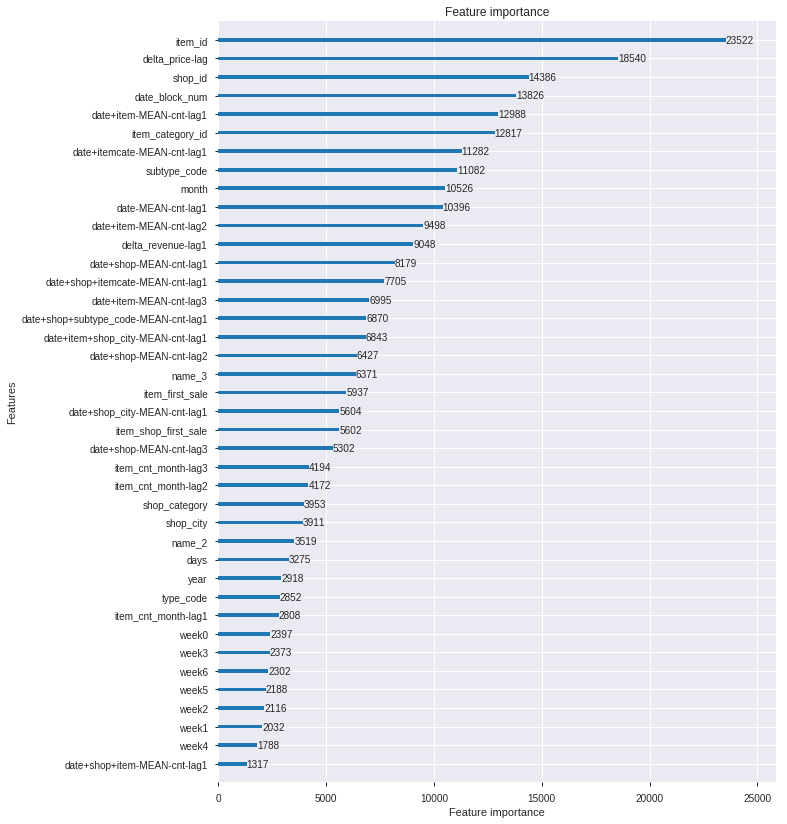

In [34]:
# from lightgbm import plot_importance
# from xgboost import plot_importance
from lightgbm import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [35]:
feat_importance = model.feature_importance()
df_importance = pd.DataFrame(feat_importance, columns=['importance'], index=X_test.columns)
df_importance = df_importance.sort_values(by='importance', ascending=False)
df_importance.index


Index(['item_id', 'delta_price-lag', 'shop_id', 'date_block_num',
       'date+item-MEAN-cnt-lag1', 'item_category_id',
       'date+itemcate-MEAN-cnt-lag1', 'subtype_code', 'month',
       'date-MEAN-cnt-lag1', 'date+item-MEAN-cnt-lag2', 'delta_revenue-lag1',
       'date+shop-MEAN-cnt-lag1', 'date+shop+itemcate-MEAN-cnt-lag1',
       'date+item-MEAN-cnt-lag3', 'date+shop+subtype_code-MEAN-cnt-lag1',
       'date+item+shop_city-MEAN-cnt-lag1', 'date+shop-MEAN-cnt-lag2',
       'name_3', 'item_first_sale', 'date+shop_city-MEAN-cnt-lag1',
       'item_shop_first_sale', 'date+shop-MEAN-cnt-lag3',
       'item_cnt_month-lag3', 'item_cnt_month-lag2', 'shop_category',
       'shop_city', 'name_2', 'days', 'year', 'type_code',
       'item_cnt_month-lag1', 'week0', 'week3', 'week6', 'week5', 'week2',
       'week1', 'week4', 'date+shop+item-MEAN-cnt-lag1'],
      dtype='object')

In [36]:
df_importance

,importance
item_id,23522
delta_price-lag,18540
shop_id,14386
date_block_num,13826
date+item-MEAN-cnt-lag1,12988
item_category_id,12817
date+itemcate-MEAN-cnt-lag1,11282
subtype_code,11082
month,10526
date-MEAN-cnt-lag1,10396
